In [2]:
# If in notebook cell
!conda install -y pytorch torchvision torchaudio cpuonly -c pytorch

Retrieving notices: done
Channels:
 - pytorch
 - defaults
 - conda-forge
Platform: osx-arm64
Solving environment: done

## Package Plan ##

  environment location: /opt/anaconda3/envs/spacenet-building-detection

  added / updated specs:
    - cpuonly
    - pytorch
    - torchaudio
    - torchvision


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2025.7.14          |   py39hca03da5_0         161 KB
    cfitsio-4.2.0              |       h2f961c4_0         731 KB  conda-forge
    cpuonly-2.0                |                0           2 KB  pytorch
    filelock-3.17.0            |   py39hca03da5_0          33 KB
    fiona-1.10.1               |   py39h313beb8_0         1.1 MB
    freexl-1.0.6               |       h1a28f6b_0          40 KB
    gdal-3.6.4                 |  py39hdc895f8_16         1.4 MB  conda-forge
    geotiff-1.7.1              |      h00e2a8a_11         115 K

In [4]:
!conda install -y -c conda-forge timm

Channels:
 - conda-forge
 - defaults
 - pytorch
Platform: osx-arm64
Solving environment: done

## Package Plan ##

  environment location: /opt/anaconda3/envs/spacenet-building-detection

  added / updated specs:
    - timm


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _python_abi3_support-1.0   |       hd8ed1ab_2           8 KB  conda-forge
    cpython-3.9.23             |   py39hd8ed1ab_0          48 KB  conda-forge
    fsspec-2025.7.0            |     pyhd8ed1ab_0         142 KB  conda-forge
    hf-xet-1.1.5               |   py39h7e234a0_3         2.2 MB  conda-forge
    huggingface_hub-0.33.4     |     pyhd8ed1ab_0         311 KB  conda-forge
    python-gil-3.9.23          |       hd8ed1ab_0          48 KB  conda-forge
    safetensors-0.5.3          |   py39hc40b5db_0         367 KB  conda-forge
    timm-1.0.17                |     pyhe01879c_0         1.6 MB  conda-forge
    ty

In [27]:
import torch
import sys
import importlib
import os

# Ensure the code directory is in the path
sys.path.append(os.path.abspath("../code"))
import model as mdl

# Reload in case you've made changes
importlib.reload(mdl)

# Print all classes in the model module
print("Model module classes:", [c for c in dir(mdl) if not c.startswith("_")])

# ---- Model Configuration ----
cnn_model = "resnet50"
num_input_channels = 3
num_classes = 1
vit_embed_dim = 768
vit_heads = 12
gat_heads = 4

print("\nInstantiating HybridGeoNet...")
net = mdl.HybridGeoNet(
    cnn_model=cnn_model,
    num_input_channels=num_input_channels,
    num_classes=num_classes,
    vit_embed_dim=vit_embed_dim,
    vit_heads=vit_heads,
    gat_heads=gat_heads,
    pretrained_cnn=False
)
print("Model instantiated:", net)

# ---- Dummy Input ----
B, C, H, W = 2, num_input_channels, 224, 224
x = torch.randn(B, C, H, W)
print(f"\nDummy input shape: {x.shape}")

# ---- Forward Pass ----
print("\nRunning forward pass...")
try:
    output = net(x)
    print("\nForward pass completed successfully.")
    print("Output shape:", output.shape)
except Exception as e:
    print("\nException during forward pass!")
    print(e)
    import traceback
    traceback.print_exc()

print("\n--- Debugging Intermediate Outputs ---")

# If you want to see more, you can monkey-patch print statements into the model code itself,
# or subclass and override forward methods to print shapes at every stage.
# For now, let's manually step through the encoder and HybridViTGATBlock:

print("\n[ENCODER] Getting multi-scale features...")
x2, x3, x4, x5 = net.cnn_encoder(x)
print("x2 (1/4 res):", x2.shape)
print("x3 (1/8 res):", x3.shape)
print("x4 (1/16 res):", x4.shape)
print("x5 (1/32 res):", x5.shape)

print("\n[ViT-GAT] Passing x5 to HybridViTGATBlock...")
vit_gat_features = net.hybrid_vit_gat_block(x5)
print("HybridViTGATBlock output:", vit_gat_features.shape)

print("\n[DECODER] Passing through decoder stages...")
x_dec = net.first_decoder_conv(vit_gat_features)
print("first_decoder_conv:", x_dec.shape)
x_dec = net.decoder_up4(x_dec, x4)
print("decoder_up4:", x_dec.shape)
x_dec = net.decoder_up3(x_dec, x3)
print("decoder_up3:", x_dec.shape)
x_dec = net.decoder_up2(x_dec, x2)
print("decoder_up2:", x_dec.shape)
x_dec = torch.nn.functional.interpolate(x_dec, size=(H, W), mode='bilinear', align_corners=False)
print("interpolated to input size:", x_dec.shape)
x_dec = net.final_conv_relu(x_dec)
print("final_conv_relu:", x_dec.shape)
output_mask = net.output_conv(x_dec)
print("output_conv (final mask):", output_mask.shape)

print("\nAll intermediate shapes printed. If you need more granularity, add print statements inside model.py itself.")

Model module classes: ['CNNEncoder', 'CustomConv1', 'Data', 'DecoderBlock', 'F', 'GATConv', 'HybridGeoNet', 'HybridViTGATBlock', 'PYG_AVAILABLE', 'PatchEmbed', 'VisionTransformer', 'models', 'nn', 'torch']

Instantiating HybridGeoNet...


/opt/anaconda3/envs/spacenet-building-detection/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


NOTE: Dummy GATConv is a linear layer. Install 'torch_geometric' for actual GAT functionality.
NOTE: Dummy GATConv is a linear layer. Install 'torch_geometric' for actual GAT functionality.
Model instantiated: HybridGeoNet(
  (cnn_encoder): CNNEncoder(
    (conv1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        

RuntimeError: Given groups=1, weight of size [32, 64, 3, 3], expected input[2, 128, 224, 224] to have 64 channels, but got 128 channels instead

In [17]:
import torch
import sys, importlib, os

# ---- Setup --------------------------------------------------------------
sys.path.append(os.path.abspath("../code"))
import model as mdl
importlib.reload(mdl)

# ---- Model config -------------------------------------------------------
net = mdl.HybridGeoNet(
    cnn_model="resnet50",
    num_input_channels=3,
    num_classes=1,
    vit_embed_dim=768,
    vit_heads=12,
    gat_heads=4,
    pretrained_cnn=False,
)

# # ---- Dummy input --------------------------------------------------------
# B, C, H, W = 2, 3, 224, 224
# x = torch.randn(B, C, H, W)

# ---- 1. Quick sanity check via net(x) -----------------------------------
out = net(x)
print("net(x) output:", out.shape)   # should be [2, 1, 224, 224]

# ---- 2. Step‑by‑step shape trace ---------------------------------------
print("\n[ENCODER]")
x2, x3, x4, x5 = net.cnn_encoder(x)
print("x2:", x2.shape, "  x3:", x3.shape, "  x4:", x4.shape, "  x5:", x5.shape)

print("\n[ViT‑GAT]")
v = net.hybrid_vit_gat_block(x5)
print("vit_gat_features:", v.shape)

print("\n[DECODER]")
d = net.first_decoder_conv(v);        print("first_decoder_conv:", d.shape)
d = net.decoder_up4(d, x4);           print("decoder_up4:", d.shape)
d = net.decoder_up3(d, x3);           print("decoder_up3:", d.shape)
d = net.decoder_up2(d, x2);           print("decoder_up2:", d.shape)

# ------------- critical line (128 → 64) ----------------------------------
d = net.final_upsample(d);            print("final_upsample:", d.shape)

d = torch.nn.functional.interpolate(d, size=(H, W),
                                    mode='bilinear', align_corners=False)
print("interpolated to input size:", d.shape)

d = net.final_conv_relu(d);           print("final_conv_relu:", d.shape)
mask = net.output_conv(d);            print("output_conv:", mask.shape)


NOTE: Dummy GATConv is a linear layer. Install 'torch_geometric' for actual GAT functionality.
NOTE: Dummy GATConv is a linear layer. Install 'torch_geometric' for actual GAT functionality.
net(x) output: torch.Size([2, 1, 224, 224])

[ENCODER]
x2: torch.Size([2, 256, 56, 56])   x3: torch.Size([2, 512, 28, 28])   x4: torch.Size([2, 1024, 14, 14])   x5: torch.Size([2, 2048, 7, 7])

[ViT‑GAT]
vit_gat_features: torch.Size([2, 192, 7, 7])

[DECODER]
first_decoder_conv: torch.Size([2, 512, 7, 7])
decoder_up4: torch.Size([2, 512, 14, 14])
decoder_up3: torch.Size([2, 256, 28, 28])
decoder_up2: torch.Size([2, 128, 56, 56])
final_upsample: torch.Size([2, 64, 112, 112])
interpolated to input size: torch.Size([2, 64, 224, 224])
final_conv_relu: torch.Size([2, 32, 224, 224])
output_conv: torch.Size([2, 1, 224, 224])


In [18]:
import boto3

bucket = "sagemaker-us-east-1-040571275415"
prefix = "spacenet-building-detection/raw_data/AOI_2_Vegas/PS-RGB/"
search_term = "img1"  # This will match img1, img10, img100, etc.

s3 = boto3.client('s3')

print(f"Searching for files containing '{search_term}' in s3://{bucket}/{prefix} ...")
paginator = s3.get_paginator('list_objects_v2')
page_iterator = paginator.paginate(Bucket=bucket, Prefix=prefix)

found = False
for page in page_iterator:
    for obj in page.get('Contents', []):
        key = obj['Key']
        if search_term in key:
            print(key)
            found = True

if not found:
    print(f"No files containing '{search_term}' found under {prefix}")

Searching for files containing 'img1' in s3://sagemaker-us-east-1-040571275415/spacenet-building-detection/raw_data/AOI_2_Vegas/PS-RGB/ ...
spacenet-building-detection/raw_data/AOI_2_Vegas/PS-RGB/SN2_buildings_train_AOI_2_Vegas_PS-RGB_img1.tif
spacenet-building-detection/raw_data/AOI_2_Vegas/PS-RGB/SN2_buildings_train_AOI_2_Vegas_PS-RGB_img10.tif
spacenet-building-detection/raw_data/AOI_2_Vegas/PS-RGB/SN2_buildings_train_AOI_2_Vegas_PS-RGB_img1002.tif
spacenet-building-detection/raw_data/AOI_2_Vegas/PS-RGB/SN2_buildings_train_AOI_2_Vegas_PS-RGB_img1003.tif
spacenet-building-detection/raw_data/AOI_2_Vegas/PS-RGB/SN2_buildings_train_AOI_2_Vegas_PS-RGB_img1004.tif
spacenet-building-detection/raw_data/AOI_2_Vegas/PS-RGB/SN2_buildings_train_AOI_2_Vegas_PS-RGB_img1006.tif
spacenet-building-detection/raw_data/AOI_2_Vegas/PS-RGB/SN2_buildings_train_AOI_2_Vegas_PS-RGB_img1007.tif
spacenet-building-detection/raw_data/AOI_2_Vegas/PS-RGB/SN2_buildings_train_AOI_2_Vegas_PS-RGB_img1009.tif
spacenet-

In [19]:
import boto3
from PIL import Image
import torchvision.transforms as T

# ---- S3 CONFIG ----
bucket = "sagemaker-us-east-1-040571275415"
key = "spacenet-building-detection/raw_data/AOI_2_Vegas/PS-RGB/SN2_buildings_train_AOI_2_Vegas_PS-RGB_img1.tif"
local_path = "img1.tif"

# ---- Download from S3 ----
s3 = boto3.client('s3')
s3.download_file(bucket, key, local_path)

# ---- Load image ----
img = Image.open(local_path)
print("Loaded image mode:", img.mode, "size:", img.size)

# ---- Preprocess ----
transform = T.Compose([
    T.Resize((224, 224)),  # or your model's expected size
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
if img.mode != 'RGB':
    img = img.convert('RGB')
img_tensor = transform(img).unsqueeze(0)  # [1, 3, 224, 224]
print("Preprocessed tensor shape:", img_tensor.shape)

UnidentifiedImageError: cannot identify image file 'img1.tif'

In [20]:
import rasterio
import numpy as np
import torch
import torchvision.transforms as T

# ---- Load TIFF with rasterio ----
with rasterio.open("img1.tif") as src:
    img_arr = src.read()  # shape: (bands, height, width)
    print("Rasterio image shape:", img_arr.shape)

# If you want RGB only (first 3 bands), use img_arr[:3, :, :]
if img_arr.shape[0] > 3:
    img_arr = img_arr[:3, :, :]
    print("Trimmed to first 3 bands (RGB):", img_arr.shape)

# ---- Convert to float32 and scale to [0,1] ----
img_arr = img_arr.astype(np.float32)
img_arr = (img_arr - img_arr.min()) / (img_arr.max() - img_arr.min() + 1e-8)

# ---- Resize to model input size (224x224) ----
# Convert to torch tensor for resizing
img_tensor = torch.from_numpy(img_arr)
img_tensor = T.functional.resize(img_tensor, [224, 224])  # expects (C, H, W)
print("Resized tensor shape:", img_tensor.shape)

# ---- Normalize (ImageNet) and batch ----
normalize = T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
img_tensor = normalize(img_tensor)
img_tensor = img_tensor.unsqueeze(0)  # [1, 3, 224, 224]

print("Ready for model, shape:", img_tensor.shape)

Rasterio image shape: (3, 650, 650)
Resized tensor shape: torch.Size([3, 224, 224])
Ready for model, shape: torch.Size([1, 3, 224, 224])


In [21]:
# Assuming img_tensor is your [1, 3, 224, 224] tensor from rasterio
with torch.no_grad():
    out = net(img_tensor)
print("Model output shape:", out.shape)  # Should be [1, 1, 224, 224]

Model output shape: torch.Size([1, 1, 224, 224])


In [25]:
import boto3

# --- Set your S3 bucket and keys ---
bucket = "sagemaker-us-east-1-040571275415"
image_key = "spacenet-building-detection/processed_masks/train/images/AOI_2_Vegas_img101.tif"
mask_key = "spacenet-building-detection/processed_masks/train/masks/AOI_2_Vegas_img101.tif"

# --- Set local filenames to save as ---
local_image = "AOI_2_Vegas_img101.tif"
local_mask = "AOI_2_Vegas_img101_mask.tif"

# --- Download from S3 ---
s3 = boto3.client("s3")
s3.download_file(bucket, image_key, local_image)
s3.download_file(bucket, mask_key, local_mask)

print("Downloaded image and mask to current directory.")

Downloaded image and mask to current directory.


Rasterio image shape: (8, 650, 650)
Trimmed to first 3 bands (RGB): (3, 650, 650)
Resized image tensor shape: torch.Size([3, 224, 224])
Ready for model, image tensor shape: torch.Size([1, 3, 224, 224])
Ready for model, mask tensor shape: torch.Size([1, 1, 224, 224])


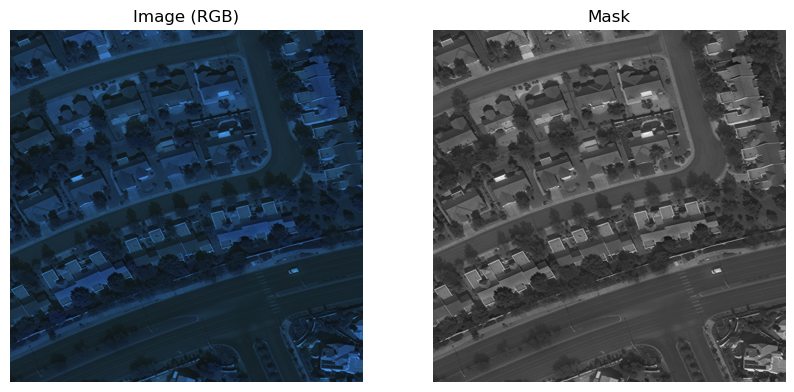

In [28]:
import rasterio
import numpy as np
import torch
import torchvision.transforms as T
import matplotlib.pyplot as plt

# ---- Set your file paths ----
image_path = "AOI_2_Vegas_img101.tif"
mask_path = "AOI_2_Vegas_img101.tif"

# ---- Load image ----
with rasterio.open(image_path) as src:
    img_arr = src.read()  # (bands, H, W)
    print("Rasterio image shape:", img_arr.shape)

# Use only first 3 bands (RGB) if needed
if img_arr.shape[0] > 3:
    img_arr = img_arr[:3, :, :]
    print("Trimmed to first 3 bands (RGB):", img_arr.shape)

# Convert to float32 and scale to [0,1]
img_arr = img_arr.astype(np.float32)
img_arr = (img_arr - img_arr.min()) / (img_arr.max() - img_arr.min() + 1e-8)

# Convert to torch tensor and resize
img_tensor = torch.from_numpy(img_arr)
img_tensor = T.functional.resize(img_tensor, [224, 224])  # (C, H, W)
print("Resized image tensor shape:", img_tensor.shape)

# Normalize (ImageNet)
normalize = T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
img_tensor = normalize(img_tensor)
img_tensor = img_tensor.unsqueeze(0)  # [1, 3, 224, 224]
print("Ready for model, image tensor shape:", img_tensor.shape)

# ---- Load mask ----
with rasterio.open(mask_path) as src_mask:
    mask_arr = src_mask.read(1).astype(np.float32)  # (H, W)
    mask_arr = np.expand_dims(mask_arr, axis=0)     # (1, H, W)

mask_tensor = torch.from_numpy(mask_arr)
mask_tensor = T.functional.resize(mask_tensor, [224, 224], interpolation=T.InterpolationMode.NEAREST)
mask_tensor = (mask_tensor > 0.5).float()  # Binarize if not already
mask_tensor = mask_tensor.unsqueeze(0)     # [1, 1, 224, 224]
print("Ready for model, mask tensor shape:", mask_tensor.shape)

# ---- Visualize image and mask ----
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(np.transpose(img_arr[:3], (1,2,0)))
plt.title("Image (RGB)")
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(mask_arr[0], cmap='gray')
plt.title("Mask")
plt.axis('off')
plt.show()

# Second Model Iteration

In [1]:
!pip install s3fs
import s3fs
import re

  Using cached aiohappyeyeballs-2.6.1-py3-none-any.whl.metadata (5.9 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 6.3 MB/s eta 0:00:00a 0:00:01
Using cached aiohappyeyeballs-2.6.1-py3-none-any.whl (15 kB)
  Attempting uninstall: botocore
    Found existing installation: botocore 1.39.7
    Uninstalling botocore-1.39.7:
      Successfully uninstalled botocore-1.39.7
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13/13 [s3fs]2m10/13 [aiohttp]]
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
boto3 1.39.7 requires botocore<1.40.0,>=1.39.7, but you have botocore 1.38.46 which is incompatible.


In [2]:
S3_BUCKET = "sagemaker-us-east-1-040571275415"
S3_PREFIX = "spacenet-building-detection/processed_masks/train"
fs = s3fs.S3FileSystem(anon=False)

In [3]:
image_files = fs.ls(f"{S3_BUCKET}/{S3_PREFIX}/images")
mask_files = fs.ls(f"{S3_BUCKET}/{S3_PREFIX}/masks")
print(f"Found {len(image_files)} images and {len(mask_files)} masks")

Found 3080 images and 3080 masks


In [4]:
def extract_id(filename):
    # Example: AOI_2_Vegas_img10.tif → AOI_2_Vegas_img10
    match = re.search(r'(AOI_2_Vegas_img\d+)', filename)
    if match:
        return match.group(1)
    match = re.search(r'_img(\d+)\\.tif', filename)
    if match:
        return f"AOI_2_Vegas_img{match.group(1)}"
    return filename.split('/')[-1].replace('.tif', '')

image_ids = set(extract_id(f) for f in image_files)
mask_ids = set(extract_id(f) for f in mask_files)

In [5]:
def extract_id(filename):
    # Example: AOI_2_Vegas_img10.tif → AOI_2_Vegas_img10
    match = re.search(r'(AOI_2_Vegas_img\d+)', filename)
    if match:
        return match.group(1)
    match = re.search(r'_img(\d+)\\.tif', filename)
    if match:
        return f"AOI_2_Vegas_img{match.group(1)}"
    return filename.split('/')[-1].replace('.tif', '')

image_ids = set(extract_id(f) for f in image_files)
mask_ids = set(extract_id(f) for f in mask_files)

In [6]:
print(f"Unique image IDs: {len(image_ids)}")
print(f"Unique mask IDs: {len(mask_ids)}")

# Images with no mask
images_without_mask = image_ids - mask_ids
# Masks with no image
masks_without_image = mask_ids - image_ids

print("Images without matching mask:", images_without_mask)
print("Masks without matching image:", masks_without_image)

if not images_without_mask and not masks_without_image:
    print("All images and masks align 1-to-1!")
else:
    print("There are mismatches. See above.")

Unique image IDs: 3080
Unique mask IDs: 3080
Images without matching mask: set()
Masks without matching image: set()
All images and masks align 1-to-1!


In [7]:
# 1. Download image and mask from S3 (your code)
import boto3

bucket = "sagemaker-us-east-1-040571275415"
image_key = "spacenet-building-detection/processed_masks/train/images/AOI_2_Vegas_img101.tif"
mask_key = "spacenet-building-detection/processed_masks/train/masks/AOI_2_Vegas_img101.tif"
local_image = "AOI_2_Vegas_img101.tif"
local_mask = "AOI_2_Vegas_img101_mask.tif"

s3 = boto3.client("s3")
s3.download_file(bucket, image_key, local_image)
s3.download_file(bucket, mask_key, local_mask)

print("Downloaded image and mask to current directory.")

Downloaded image and mask to current directory.


In [8]:
# 2. Load the image and mask using rasterio
import rasterio
import numpy as np

with rasterio.open(local_image) as src_img:
    image = src_img.read().astype(np.float32) / 65535.0  # (C, H, W), scale to 0-1
    image = np.transpose(image, (1, 2, 0))               # (H, W, C) for Albumentations

with rasterio.open(local_mask) as src_mask:
    mask = src_mask.read(1).astype(np.uint8)             # (H, W)

In [11]:
%pip install albumentations --quiet

Note: you may need to restart the kernel to use updated packages.


In [12]:
# 3. Define Albumentations transform (example: resize, normalize, to tensor)
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Replace with your actual mean and std for MS images
DATASET_MEAN = [0.15, 0.14, 0.13, 0.12, 0.11, 0.10, 0.09, 0.08]
DATASET_STD = [0.05, 0.04, 0.05, 0.04, 0.03, 0.04, 0.03, 0.02]

transform = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Normalize(mean=DATASET_MEAN, std=DATASET_STD, max_pixel_value=1.0),
    ToTensorV2()
])

augmented = transform(image=image, mask=mask)
image_tensor = augmented["image"]  # shape: (C, H, W)
mask_tensor = augmented["mask"].unsqueeze(0)  # shape: (1, H, W)

print("Transformed image tensor shape:", image_tensor.shape)
print("Transformed mask tensor shape:", mask_tensor.shape)

/opt/anaconda3/envs/spacenet-building-detection/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Transformed image tensor shape: torch.Size([8, 224, 224])
Transformed mask tensor shape: torch.Size([1, 224, 224])


In [16]:
# 4. Load your model and run a forward pass
import torch
import sys
from code.model import HybridGeoNet

model = HybridGeoNet(num_input_channels=image_tensor.shape[0], num_classes=1)
model.eval()

with torch.no_grad():
    output = model(image_tensor.unsqueeze(0))  # Add batch dimension
    print("Model output shape:", output.shape)

ModuleNotFoundError: No module named 'code.model'; 'code' is not a package

In [18]:
# 4. Load your model and run a forward pass

import torch
import sys
sys.path.append("..")  # Adjust if your notebook is in 'notebooks/'. Use '.' if in project root.

from code.model import HybridGeoNet

# Initialize the model with the correct number of input channels (e.g., 8 for MS)
model = HybridGeoNet(num_input_channels=image_tensor.shape[0], num_classes=1)
model.eval()

with torch.no_grad():
    output = model(image_tensor.unsqueeze(0))  # Add batch dimension: (1, C, H, W)
    print("Model output shape:", output.shape)

ModuleNotFoundError: No module named 'code.model'; 'code' is not a package

In [19]:
import sys
import os

# Adjust the path below if your notebook is in a different location
code_dir = os.path.abspath("../code")  # For notebooks/ directory
if code_dir not in sys.path:
    sys.path.insert(0, code_dir)

from model import HybridGeoNet

model = HybridGeoNet(num_input_channels=image_tensor.shape[0], num_classes=1)
model.eval()

with torch.no_grad():
    output = model(image_tensor.unsqueeze(0))  # Add batch dimension
    print("Model output shape:", output.shape)

/opt/anaconda3/envs/spacenet-building-detection/lib/python3.9/site-packages/torchvision/io/image.py:14: UserWarning: Failed to load image Python extension: 'dlopen(/opt/anaconda3/envs/spacenet-building-detection/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libjpeg.9.dylib
  Referenced from: <FB2FD416-6C4D-3621-B677-61F07C02A3C5> /opt/anaconda3/envs/spacenet-building-detection/lib/python3.9/site-packages/torchvision/image.so
  Reason: tried: '/opt/anaconda3/envs/spacenet-building-detection/lib/python3.9/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/spacenet-building-detection/lib/python3.9/site-packages/torchvision/../../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/spacenet-building-detection/lib/python3.9/lib-dynload/../../libjpeg.9.dylib' (no such file), '/opt/anaconda3/envs/spacenet-building-detection/bin/../lib/libjpeg.9.dylib' (no such file)'If you don't plan on using image functionality

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /Users/nick/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:07<00:00, 13.1MB/s]


NOTE: Dummy GATConv is a linear layer. Install 'torch_geometric' for actual GAT functionality.
NOTE: Dummy GATConv is a linear layer. Install 'torch_geometric' for actual GAT functionality.
Model output shape: torch.Size([1, 1, 224, 224])


In [20]:
# 1. Load the 8-band image and mask using rasterio
import rasterio
import numpy as np

with rasterio.open(local_image) as src_img:
    image = src_img.read().astype(np.float32) / 65535.0  # (C, H, W), scale to 0-1
    print("Rasterio image shape:", image.shape)
    # Do NOT trim to first 3 bands; use all 8 bands for MS

image = np.transpose(image, (1, 2, 0))  # (H, W, C) for Albumentations

with rasterio.open(local_mask) as src_mask:
    mask = src_mask.read(1).astype(np.uint8)  # (H, W)

# 2. Define Albumentations transform for 8-band images
import albumentations as A
from albumentations.pytorch import ToTensorV2

DATASET_MEAN = [0.15, 0.14, 0.13, 0.12, 0.11, 0.10, 0.09, 0.08]
DATASET_STD = [0.05, 0.04, 0.05, 0.04, 0.03, 0.04, 0.03, 0.02]

transform = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Normalize(mean=DATASET_MEAN, std=DATASET_STD, max_pixel_value=1.0),
    ToTensorV2()
])

augmented = transform(image=image, mask=mask)
image_tensor = augmented["image"]  # shape: (8, 224, 224)
mask_tensor = augmented["mask"].unsqueeze(0)  # shape: (1, 224, 224)

print("Transformed image tensor shape:", image_tensor.shape)
print("Transformed mask tensor shape:", mask_tensor.shape)

# 3. Load your model and run a forward pass for 8 channels
import sys
import os

code_dir = os.path.abspath("../code")  # Adjust if your notebook is in 'notebooks/'
if code_dir not in sys.path:
    sys.path.insert(0, code_dir)

from model import HybridGeoNet

model = HybridGeoNet(num_input_channels=8, num_classes=1)
model.eval()

import torch
with torch.no_grad():
    output = model(image_tensor.unsqueeze(0))  # Add batch dimension: (1, 8, 224, 224)
    print("Model output shape:", output.shape)

Rasterio image shape: (8, 650, 650)
Transformed image tensor shape: torch.Size([8, 224, 224])
Transformed mask tensor shape: torch.Size([1, 224, 224])
NOTE: Dummy GATConv is a linear layer. Install 'torch_geometric' for actual GAT functionality.
NOTE: Dummy GATConv is a linear layer. Install 'torch_geometric' for actual GAT functionality.
Model output shape: torch.Size([1, 1, 224, 224])


In [23]:
import sys
import os

# Print working directory and sys.path for debugging
print("Notebook working directory:", os.getcwd())
print("sys.path:", sys.path)

# Ensure project root is in sys.path
project_root = "/Users/nick/ai-enumeration"
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# Print contents of code directory for sanity check
print("code/ directory contents:", os.listdir(os.path.join(project_root, "code")))

# Now try import
from code.dataset import SpaceNetBuildingDataset
print("Import successful!")

Notebook working directory: /Users/nick/ai-enumeration/notebooks
sys.path: ['/Users/nick/ai-enumeration', '/Users/nick/ai-enumeration/code', '/opt/anaconda3/envs/spacenet-building-detection/lib/python39.zip', '/opt/anaconda3/envs/spacenet-building-detection/lib/python3.9', '/opt/anaconda3/envs/spacenet-building-detection/lib/python3.9/lib-dynload', '', '/opt/anaconda3/envs/spacenet-building-detection/lib/python3.9/site-packages', './code', '..', '..', '/var/folders/pj/bmp5122d3d77bzq_cvf0wbl40000gn/T/tmpw278r0rw']
code/ directory contents: ['requirements.txt', '__init__.py', '__pycache__', 'model.py', 'dataset.py', 'train.py']


ModuleNotFoundError: No module named 'code.dataset'; 'code' is not a package

In [24]:
import sys
# Remove any direct code/ entries from sys.path
sys.path = [p for p in sys.path if not p.rstrip("/").endswith("code")]

# Now ensure project root is present
project_root = "/Users/nick/ai-enumeration"
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print("sys.path:", sys.path)

from code.dataset import SpaceNetBuildingDataset
print("Import successful!")

sys.path: ['/Users/nick/ai-enumeration', '/opt/anaconda3/envs/spacenet-building-detection/lib/python39.zip', '/opt/anaconda3/envs/spacenet-building-detection/lib/python3.9', '/opt/anaconda3/envs/spacenet-building-detection/lib/python3.9/lib-dynload', '', '/opt/anaconda3/envs/spacenet-building-detection/lib/python3.9/site-packages', '..', '..', '/var/folders/pj/bmp5122d3d77bzq_cvf0wbl40000gn/T/tmpw278r0rw']


ModuleNotFoundError: No module named 'code.dataset'; 'code' is not a package

In [25]:
!ls /Users/nick/ai-enumeration | grep code

code


In [26]:
import importlib.util
spec = importlib.util.spec_from_file_location("dataset", "/Users/nick/ai-enumeration/code/dataset.py")
dataset = importlib.util.module_from_spec(spec)
spec.loader.exec_module(dataset)
SpaceNetBuildingDataset = dataset.SpaceNetBuildingDataset
print("Direct import successful!")

Direct import successful!


In [22]:
import sys
import os

# Always add the project root to sys.path
project_root = os.path.abspath("..")  # one directory up from /notebooks
if project_root not in sys.path:
    sys.path.insert(0, project_root)

print("sys.path:", sys.path)  # Debug: see if project root is included

from code.dataset import SpaceNetBuildingDataset

sys.path: ['/Users/nick/ai-enumeration', '/Users/nick/ai-enumeration/code', '/opt/anaconda3/envs/spacenet-building-detection/lib/python39.zip', '/opt/anaconda3/envs/spacenet-building-detection/lib/python3.9', '/opt/anaconda3/envs/spacenet-building-detection/lib/python3.9/lib-dynload', '', '/opt/anaconda3/envs/spacenet-building-detection/lib/python3.9/site-packages', './code', '..', '..', '/var/folders/pj/bmp5122d3d77bzq_cvf0wbl40000gn/T/tmpw278r0rw']


ModuleNotFoundError: No module named 'code.dataset'; 'code' is not a package

In [21]:
from code.dataset import SpaceNetBuildingDataset

# Simulate local SageMaker channel paths
local_train_image_dir = "/path/to/local/train_images"
local_train_mask_dir = "/path/to/local/train_masks"

# If your class supports local mode by omitting s3_bucket:
dataset = SpaceNetBuildingDataset(
    s3_bucket=None,
    image_s3_path_prefix=local_train_image_dir,
    mask_s3_path_prefix=local_train_mask_dir,
    augment_mode='train',
    num_input_channels=8
)

# Test loading a sample
img, mask = dataset[0]
print("Image shape:", img.shape)
print("Mask shape:", mask.shape)

ModuleNotFoundError: No module named 'code.dataset'; 'code' is not a package

In [28]:
import sys
import os
sys.path.append(os.path.abspath("../code"))

import dataset
SpaceNetBuildingDataset = dataset.SpaceNetBuildingDataset